In [ ]:
from dotenv import load_dotenv
load_dotenv()  

True

In [ ]:
import os
import re
import logging
import concurrent.futures
import statistics
from typing import List, TypedDict, Dict, Any

import numpy as np
import pandas as pd
from dotenv import load_dotenv


from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Pinecone

from pinecone import Pinecone as PineconeClient, ServerlessSpec
from tavily import TavilyClient


from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver


load_dotenv()  
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def get_env_param(key: str, default: str) -> str:
    return os.getenv(key, default)


CHUNK_SIZE = int(get_env_param("CHUNK_SIZE", "500"))
CHUNK_OVERLAP = int(get_env_param("CHUNK_OVERLAP", "50"))
MAX_REVISIONS = int(get_env_param("MAX_REVISIONS", "3"))

# Required API keys 
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
if not all([OPENAI_API_KEY, PINECONE_API_KEY, TAVILY_API_KEY]):
    raise ValueError("Missing one or more required API keys. Check your environment variables.")

# ------------------------------
# Initialize External Clients and Models
# ------------------------------
embedding_function = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=OPENAI_API_KEY)
llm_model = ChatOpenAI(model="gpt-4", temperature=0)
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

# ------------------------------
# Pinecone Initialization and Index Management
# ------------------------------
INDEX_NAME = "promptwithrag"
pc = PineconeClient(api_key=PINECONE_API_KEY)

def manage_pinecone_index() -> None:
    try:
        existing_indexes = pc.list_indexes().names()
        if INDEX_NAME in existing_indexes:
            logging.info(f"Pinecone index '{INDEX_NAME}' already exists.")
        else:
            logging.info(f"Creating Pinecone index '{INDEX_NAME}'...")
            spec = ServerlessSpec(cloud="aws", region="us-east-1")
            pc.create_index(name=INDEX_NAME, dimension=1536, metric="cosine", spec=spec)
            logging.info(f"Pinecone index '{INDEX_NAME}' created successfully.")
    except Exception as e:
        logging.exception("Error managing Pinecone index: %s", e)

manage_pinecone_index()
index = pc.Index(INDEX_NAME)

# ------------------------------
# Data Loading and Preprocessing
# ------------------------------
def load_json_file(file_path: str) -> pd.DataFrame:
    if not os.path.exists(file_path):
        logging.error("File not found: %s", file_path)
        return pd.DataFrame()
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            df = pd.read_json(f)
        logging.info("Loaded %d records from %s", len(df), file_path)
        return df
    except Exception as e:
        logging.exception("Error loading file %s: %s", file_path, e)
        return pd.DataFrame()

def combine_text_columns(df: pd.DataFrame, expected_columns: List[str], new_col_name: str) -> pd.DataFrame:
    present_columns = [col for col in expected_columns if col in df.columns]
    if not present_columns:
        present_columns = df.select_dtypes(include="object").columns.tolist()
        logging.warning("No expected columns for '%s'; using all text columns: %s", new_col_name, present_columns)
    df[new_col_name] = df[present_columns].fillna("").agg(" ".join, axis=1)
    return df

def chunk_documents(df: pd.DataFrame, text_column: str, source: str) -> List[Dict[str, Any]]:
    result = []
    splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
    for doc_idx, row in df.iterrows():
        text = row.get(text_column, "")
        if not text or len(text) < 100:
            continue
        for i, chunk in enumerate(splitter.split_text(text)):
            result.append({
                "doc_id": f"{source}_{doc_idx}",
                "chunk_id": i,
                "text": chunk,
                "source": source
            })
    return result

def upsert_embeddings(df_chunks: pd.DataFrame) -> None:
    chunk_texts = df_chunks["text"].tolist()
    try:
        chunk_embeddings = embedding_function.embed_documents(chunk_texts)
    except Exception as e:
        logging.exception("Error generating embeddings: %s", e)
        return

    def process_batch(batch: List[tuple]) -> bool:
        try:
            index.upsert(vectors=batch)
            return True
        except Exception as e:
            logging.exception("Error upserting batch: %s", e)
            return False

    upsert_data = [
        (
            f"{row['doc_id']}_{row['chunk_id']}",
            chunk_embeddings[idx],
            {"doc_id": row["doc_id"], "chunk_id": row["chunk_id"], "text": row["text"], "source": row["source"]}
        )
        for idx, row in df_chunks.iterrows()
    ]
    batch_size = 50
    batches = [upsert_data[i:i + batch_size] for i in range(0, len(upsert_data), batch_size)]
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_batch, batches))
    successful_batches = sum(results)
    logging.info("Upsert completed: %d out of %d batches succeeded.", successful_batches, len(batches))


countries_df = load_json_file("../data/all_countries_info.json")
companies_df = load_json_file("../data/company_info.json")
countries_df = combine_text_columns(countries_df, ["Summary", "Economy", "Culture"], "country_description")
companies_df = combine_text_columns(companies_df, ["Background", "Industry", "Achievements", "Impact"], "company_description")
chunks = []
chunks.extend(chunk_documents(countries_df, "country_description", "country"))
chunks.extend(chunk_documents(companies_df, "company_description", "company"))
df_chunks = pd.DataFrame(chunks)
upsert_embeddings(df_chunks)
vectorstore = Pinecone.from_existing_index(index_name=INDEX_NAME, embedding=embedding_function)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# ------------------------------
# Agent State and Prompt Templates
# ------------------------------
class AgentState(TypedDict):
    company_name: str
    country_name: str
    company_info: str
    country_info: str
    retrieved_info: List[str]
    event_context: str
    audience_profile: str
    plan: str
    content_draft: str
    review_feedback: str
    collaboration_draft: str
    formatted_speech: str
    reflection: str
    readability_score: float
    draft_speech: str
    revision_number: int
    max_revisions: int
    user_feedback: str

PLAN_CREATION_PROMPT = """
You are a strategic planner. Given the event "{event_context}" and the audience "{audience_profile}",
create a detailed step-by-step plan to write an engaging speech that incorporates company and country insights.
Include steps like: gathering information, outlining, drafting, reviewing, and finalizing.
"""

CONTENT_AGENT_PROMPT = """
You are the Content Agent. Using the following information, produce an initial draft of the speech.
Company Information:
{company_info}

Country Information:
{country_info}

Plan:
{plan}

Generate a speech draft with a clear introduction, body, and conclusion.
"""

REVIEW_AGENT_PROMPT = """
You are the Review Agent. Critically review the following speech draft:
{content_draft}
Provide detailed feedback on structure, clarity, engagement, and suggestions for improvement.
"""

COLLABORATION_PROMPT = """
The Content Agent produced the following draft:
{content_draft}

The Review Agent provided the following feedback:
{review_feedback}

Collaboratively generate an improved version of the speech draft that incorporates the feedback.
"""

FORMAT_SPEECH_PROMPT = """
Organize the following draft into a well-structured speech with these sections:
1. Introduction
2. Body
3. Conclusion

Draft:
{collaboration_draft}
"""

REFLECTION_PROMPT = """
Reflect on the following speech:
{formatted_speech}

Describe its strengths and weaknesses and propose ways to improve the process in future iterations.
"""

USER_FEEDBACK_PROMPT = """
Incorporate the following user feedback into the speech to improve its quality.

User Feedback:
{user_feedback}

Current Speech:
{formatted_speech}
"""


def llm_call(prompt: str, additional_messages: List[Dict[str, str]] = None) -> str:
    messages = [{"role": "system", "content": prompt}]
    if additional_messages:
        messages.extend(additional_messages)
    try:
        response = llm_model(messages)
        return response.content
    except Exception as e:
        logging.error("LLM call error: %s", e)
        return f"Error: {str(e)}"

def compute_enhanced_readability(text: str) -> Dict[str, float]:
    try:
        words = re.findall(r'\w+', text)
        sentences = re.split(r'[.!?]+', text)
        sentences = [s for s in sentences if s.strip()]
        avg_word_length = statistics.mean([len(word) for word in words]) if words else 0.0
        avg_sentence_length = statistics.mean([len(re.findall(r'\w+', s)) for s in sentences]) if sentences else 0.0
        sentence_count = len(sentences)
        return {
            "avg_word_length": avg_word_length,
            "avg_sentence_length": avg_sentence_length,
            "sentence_count": float(sentence_count)
        }
    except Exception as e:
        logging.error("Error computing readability metrics: %s", e)
        return {"avg_word_length": 0.0, "avg_sentence_length": 0.0, "sentence_count": 0.0}

def validate_state(state: AgentState) -> None:
    required_fields = ["company_name", "country_name", "event_context", "audience_profile"]
    for field in required_fields:
        if not state.get(field) or not isinstance(state.get(field), str) or not state[field].strip():
            raise ValueError(f"State missing or invalid required field: {field}")
    if state.get("max_revisions", 0) <= 0:
        raise ValueError("max_revisions must be a positive integer.")


def retrieve_company_info(state: AgentState) -> Dict[str, Any]:
    query = f"{state['company_name']} company overview, achievements, industry, and impact"
    try:
        response = tavily_client.search(query=query, max_results=3)
        if "results" in response:
            info_list = [
                f"{item.get('content', '')} (Source: {item.get('source', 'Unknown')})"
                for item in response["results"]
            ]
            info = "\n".join(info_list)
        else:
            info = "Company information not retrieved."
    except Exception as e:
        logging.error("Error retrieving company info: %s", e)
        info = "Error during company info retrieval."
    print("Step 1: Retrieved Company Info:\n", info)
    return {"company_info": info}

def retrieve_country_info(state: AgentState) -> Dict[str, Any]:
    query = f"{state['country_name']} economic landscape, culture, and business environment"
    try:
        response = tavily_client.search(query=query, max_results=3)
        if "results" in response:
            info_list = [
                f"{item.get('content', '')} (Source: {item.get('source', 'Unknown')})"
                for item in response["results"]
            ]
            info = "\n".join(info_list)
        else:
            info = "Country information not retrieved."
    except Exception as e:
        logging.error("Error retrieving country info: %s", e)
        info = "Error during country info retrieval."
    print("Step 2: Retrieved Country Info:\n", info)
    return {"country_info": info}

def retrieve_external_info(state: AgentState) -> Dict[str, Any]:
    try:
        company_retrieval = retriever.invoke(f"{state['company_name']} company background")
        country_retrieval = retriever.invoke(f"{state['country_name']} country economic landscape")
        combined_results = company_retrieval + country_retrieval
        annotated_results = []
        for doc in combined_results:
            if isinstance(doc, dict):
                text = doc.get("page_content", doc.get("text", ""))
                metadata = doc.get("metadata", {})
                source = metadata.get("source", "Unknown")
                annotated_results.append(f"{text} (Source: {source})")
            else:
                annotated_results.append(str(doc))
        retrieved_info = annotated_results
    except Exception as e:
        logging.error("Error retrieving external info: %s", e)
        retrieved_info = []
    print("Step 3: Retrieved External Info:\n", retrieved_info)
    return {"retrieved_info": retrieved_info}

def plan_creation(state: AgentState) -> Dict[str, Any]:
    prompt = PLAN_CREATION_PROMPT.format(
        event_context=state["event_context"],
        audience_profile=state["audience_profile"]
    )
    plan = llm_call(prompt, [{"role": "user", "content": "Create the plan."}])
    print("Step 4: Generated Plan:\n", plan)
    return {"plan": plan}

def content_agent(state: AgentState) -> Dict[str, Any]:
    prompt = CONTENT_AGENT_PROMPT.format(
        company_info=state["company_info"],
        country_info=state["country_info"],
        plan=state["plan"]
    )
    content_draft = llm_call(prompt, [{"role": "user", "content": "Generate the speech draft."}])
    print("Step 5: Content Agent Draft:\n", content_draft)
    return {"content_draft": content_draft, "draft_speech": content_draft}

def review_agent(state: AgentState) -> Dict[str, Any]:
    prompt = REVIEW_AGENT_PROMPT.format(content_draft=state["content_draft"])
    review_feedback = llm_call(prompt, [{"role": "user", "content": "Provide detailed feedback."}])
    print("Step 6: Review Agent Feedback:\n", review_feedback)
    return {"review_feedback": review_feedback}

def collaboration_agent(state: AgentState) -> Dict[str, Any]:
    prompt = COLLABORATION_PROMPT.format(
        content_draft=state["content_draft"],
        review_feedback=state["review_feedback"]
    )
    collaboration_draft = llm_call(prompt, [{"role": "user", "content": "Collaborate and produce an improved draft."}])
    print("Step 7: Collaboration Agent Draft:\n", collaboration_draft)
    return {"collaboration_draft": collaboration_draft}

def format_speech(state: AgentState) -> Dict[str, Any]:
    prompt = FORMAT_SPEECH_PROMPT.format(collaboration_draft=state["collaboration_draft"])
    formatted_speech = llm_call(prompt, [{"role": "user", "content": "Format the speech."}])
    print("Step 8: Formatted Speech:\n", formatted_speech)
    return {"formatted_speech": formatted_speech}

def compute_readability(state: AgentState) -> Dict[str, Any]:
    metrics = compute_enhanced_readability(state["formatted_speech"])
    print("Step 9: Readability Metrics:\n", metrics)
    return {"readability_score": metrics["avg_word_length"]}

def reflect(state: AgentState) -> Dict[str, Any]:
    prompt = REFLECTION_PROMPT.format(formatted_speech=state["formatted_speech"])
    reflection = llm_call(prompt, [{"role": "user", "content": "Reflect on the process and suggest improvements."}])
    print("Step 10: Reflection:\n", reflection)
    return {"reflection": reflection}

def incorporate_user_feedback(state: AgentState) -> Dict[str, Any]:
    if not state.get("user_feedback", "").strip():
        return {}
    prompt = USER_FEEDBACK_PROMPT.format(
        user_feedback=state["user_feedback"],
        formatted_speech=state["formatted_speech"]
    )
    updated_speech = llm_call(prompt, [{"role": "user", "content": "Incorporate this feedback."}])
    print("Incorporated User Feedback:\n", updated_speech)
    return {"formatted_speech": updated_speech}

def should_continue(state: AgentState) -> Dict[str, Any]:
    
    if state["revision_number"] < state["max_revisions"]:
        state["revision_number"] += 1
       
        if state.get("user_feedback", "").strip():
            return {"next": "incorporate_user_feedback"}
        else:
            return {"next": "content_agent"}
    else:
        return {"next": "finalize"}

def finalize(state: AgentState) -> Dict[str, Any]:
    print("Final Output Reached. Final Speech:\n", state["formatted_speech"])
    return state



2025-02-13 10:57:56,954 - INFO - Discovering subpackages in _NamespacePath(['/home/habte/anaconda3/lib/python3.12/site-packages/pinecone_plugins'])
2025-02-13 10:57:56,960 - INFO - Looking for plugins in pinecone_plugins.inference
2025-02-13 10:57:57,087 - INFO - Installing plugin inference into Pinecone
2025-02-13 10:57:57,940 - INFO - Pinecone index 'promptwithrag' already exists.
2025-02-13 10:57:58,429 - INFO - Loaded 249 records from /home/habte/data/all_countries_info.json
2025-02-13 10:57:58,445 - INFO - Loaded 94 records from /home/habte/data/company_info.json
2025-02-13 10:58:07,669 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-13 10:58:14,527 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-13 10:58:21,591 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-13 10:58:28,965 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 O

In [ ]:

def build_workflow_graph() -> StateGraph:
    builder = StateGraph(AgentState)
    
    # Data retrieval nodes
    builder.add_node("fetch_company_info", retrieve_company_info)
    builder.add_node("fetch_country_info", retrieve_country_info)
    builder.add_node("retrieve_external_info", retrieve_external_info)
    
    # Planning and collaboration nodes
    builder.add_node("plan_creation", plan_creation)
    builder.add_node("content_agent", content_agent)
    builder.add_node("review_agent", review_agent)
    builder.add_node("collaboration_agent", collaboration_agent)
    builder.add_node("format_speech", format_speech)
    
    # Tool use and reflection nodes
    builder.add_node("compute_readability", compute_readability)
    builder.add_node("reflect", reflect)
    builder.add_node("incorporate_user_feedback", incorporate_user_feedback)
    
    # Revision controller node and finalization
    builder.add_node("should_continue", should_continue)
    builder.add_node("finalize", finalize)
    
    # Define workflow flow (edges)
    builder.set_entry_point("fetch_company_info")
    builder.add_edge("fetch_company_info", "fetch_country_info")
    builder.add_edge("fetch_country_info", "retrieve_external_info")
    builder.add_edge("retrieve_external_info", "plan_creation")
    builder.add_edge("plan_creation", "content_agent")
    builder.add_edge("content_agent", "review_agent")
    builder.add_edge("review_agent", "collaboration_agent")
    builder.add_edge("collaboration_agent", "format_speech")
    builder.add_edge("format_speech", "compute_readability")
    builder.add_edge("compute_readability", "reflect")
    builder.add_edge("reflect", "should_continue")
    builder.add_edge("should_continue", "incorporate_user_feedback")
    builder.add_edge("incorporate_user_feedback", "review_agent")
    builder.add_edge("should_continue", "content_agent")
    builder.add_edge("should_continue", "finalize")
    
    memory = MemorySaver()
    return builder.compile(checkpointer=memory)

In [ ]:

def main() -> None:
    initial_state: AgentState = {
        "company_name": "Ethio Telecom",
        "country_name": "Ethiopia",
        "company_info": "",
        "country_info": "",
        "retrieved_info": [],
        "event_context": "Annual Conference 2025",
        "audience_profile": "leaders",
        "plan": "",
        "content_draft": "",
        "review_feedback": "",
        "collaboration_draft": "",
        "formatted_speech": "",
        "reflection": "",
        "readability_score": 0.0,
        "draft_speech": "",
        "revision_number": 1,
        "max_revisions": MAX_REVISIONS,
        "user_feedback": ""  
    }
    
    try:
        validate_state(initial_state)
    except ValueError as ve:
        logging.error("Initial state validation error: %s", ve)
        return
    
    workflow_graph = build_workflow_graph()
    try:
        output = workflow_graph.invoke(initial_state, config={
            "configurable": {"thread_id": "session_text_only_v2"},
            "recursion_limit": 10
        })
        logging.info("Final Agent Output:\n%s", output)
        print("\n=== Final Agent Output ===\n", output)
    except Exception as e:
        logging.error("Error during workflow execution: %s", e)

# Execute the workflow 
main()


Step 1: Retrieved Company Info:
 Ethio Telecom Corporation provides integrated telecommunication services. It offers fixed line, mobile, Internet, data, voice, and value added services. The company was formerly known as Ethiopia Telecommunications Corporation. Ethio Telecom Corporation was founded in 2010 and is headquartered in Addis Ababa, Ethiopia. digitGaps report on Ethio Telecom Corporation delivers a detailed in-depth (Source: Unknown)
Establishment of Ethio telecom. As a continuation of the 2005/06-2009/10 five-year plan and after concentrating its efforts on education, health and agriculture, the Ethiopian government decided to focus on the improvement of telecommunication services considering them as key lever in the development of Ethiopia. (Source: Unknown)
Ethio telecom 2023/2024 Annual Business Performance Report. July 10, 2024 ... The telecom industry plays a pivotal role in fostering inclusive development and enhancing the competitiveness of our country. Our longstandin

2025-02-13 11:01:35,446 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-13 11:01:38,557 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Step 3: Retrieved External Info:
 ["page_content='from the present 4,000 kilometers to 10,000 by 2010. It is part of a larger US$2.4 billion plan by the Ethiopian government to improve the country's telecommunications infrastructure. In 2018, the mobile service business has reached 85% of the country. In February 2018, it was reported that Ethio telecom had 64.4 million subscribers making it the largest telecommunication services operator in the continent. The operator runs three terrestrial fiber optic cables with a capacity of 42 Gbit/s to' metadata={'chunk_id': 3.0, 'doc_id': 'company_81', 'source': 'company'}", "page_content='In late 2006, the ETC signed an agreement worth US$1.5 billion with three Chinese companies, ZTE Corporation, Huawei Technologies and the Chinese International Telecommunication Construction Corporation, to upgrade and expand Ethiopian telecommunications services. This agreement will increase the number of mobile services from 1.5 million to 7 million, land li

/tmp/ipykernel_23145/3325734543.py:272: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm_model(messages)
2025-02-13 11:01:56,846 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 4: Generated Plan:
 Step 1: Understand the Audience and Event
Start by understanding the audience, in this case, leaders. Research their interests, challenges, and expectations. Also, understand the context of the Annual Conference 2025. What are the key themes? What are the objectives of the conference? 

Step 2: Gather Information
Start gathering information about the company and the country. This includes the company's achievements, challenges, future plans, and how it aligns with the country's economic, social, and political landscape. Use reliable sources such as company reports, industry reports, news articles, and government publications. 

Step 3: Identify Key Messages
Based on your understanding of the audience and the information gathered, identify the key messages you want to convey in your speech. These should be relevant to the audience and the event.

Step 4: Create an Outline
Create an outline for your speech. This should include an introduction, main points, and a 

2025-02-13 11:02:20,194 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 5: Content Agent Draft:
 Ladies and Gentlemen,

I am honored to stand before you today at the Annual Conference 2025, to share the journey and achievements of Ethio Telecom Corporation, a company that has been at the forefront of Ethiopia's telecommunications revolution. 

Ethio Telecom, formerly known as Ethiopia Telecommunications Corporation, was founded in 2010. Our mission has always been to provide integrated telecommunication services, including fixed line, mobile, internet, data, voice, and value-added services. We are proud to be headquartered in the vibrant city of Addis Ababa, the heart of Ethiopia.

Our company's establishment was a strategic decision by the Ethiopian government, which recognized the pivotal role of telecommunications in the development of our nation. As a result, we have been a key player in the transformation of Ethiopia's economic landscape, contributing to the country's remarkable growth and making it one of the fastest-growing economies in Africa.

2025-02-13 11:02:35,860 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 6: Review Agent Feedback:
 The speech is well-structured and clear, with a logical flow of ideas. It begins with an introduction of the speaker and the company, Ethio Telecom, followed by a brief history and the company's mission. The speaker then discusses the company's role in Ethiopia's economic development and its future plans. The conclusion wraps up the speech nicely, expressing gratitude to stakeholders and looking forward to future growth and innovation.

However, there are a few areas that could be improved to increase engagement and clarity:

1. Storytelling: While the speech provides a lot of information, it lacks personal anecdotes or stories that could make it more engaging. The speaker could share a specific example of how Ethio Telecom has impacted the lives of Ethiopians or a particular challenge the company has overcome.

2. Use of Data: The speech could benefit from the inclusion of specific data or statistics to support the claims made. For instance, when discus

2025-02-13 11:03:12,112 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 7: Collaboration Agent Draft:
 Ladies and Gentlemen,

I am deeply honored to stand before you today at the Annual Conference 2025, to share the remarkable journey and achievements of Ethio Telecom Corporation, a company that has been a catalyst in Ethiopia's telecommunications revolution. 

Ethio Telecom, formerly known as Ethiopia Telecommunications Corporation, was founded in 2010. Our mission, from the very beginning, has been to provide a comprehensive range of telecommunication services. To put it simply, we aim to connect people, whether through fixed line, mobile, internet, or voice services. We are proud to call the vibrant city of Addis Ababa, the heart of Ethiopia, our home.

Let me take you back to the inception of our company. The Ethiopian government, recognizing the crucial role of telecommunications in the development of our nation, made a strategic decision to establish Ethio Telecom. This decision has been instrumental in transforming Ethiopia's economic landscape

2025-02-13 11:03:45,241 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 8: Formatted Speech:
 Introduction:
Ladies and Gentlemen, I am deeply honored to stand before you today at the Annual Conference 2025, to share the remarkable journey and achievements of Ethio Telecom Corporation, a company that has been a catalyst in Ethiopia's telecommunications revolution. Ethio Telecom, formerly known as Ethiopia Telecommunications Corporation, was founded in 2010 with a mission to provide a comprehensive range of telecommunication services. We are proud to call the vibrant city of Addis Ababa, the heart of Ethiopia, our home.

Body:
Let me take you back to the inception of our company. The Ethiopian government, recognizing the crucial role of telecommunications in the development of our nation, made a strategic decision to establish Ethio Telecom. This decision has been instrumental in transforming Ethiopia's economic landscape, contributing to the country's remarkable growth and making it one of the fastest-growing economies in Africa.

Now, you might be won

2025-02-13 11:04:00,550 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 10: Reflection:
 Strengths:
1. The speech is well-structured with a clear introduction, body, and conclusion. 
2. The speaker effectively uses storytelling to engage the audience, taking them back to the inception of the company and highlighting its achievements.
3. The speaker provides concrete data to support their claims about the company's impact on Ethiopia's economy.
4. The speaker effectively communicates the company's future plans and expresses gratitude to stakeholders, which helps to build rapport with the audience.

Weaknesses:
1. The speech could benefit from more specific examples of the company's achievements. For instance, the speaker could mention specific projects or initiatives that have contributed to Ethiopia's economic growth.
2. The speaker could also provide more details about the company's future plans. For example, what kind of infrastructure investments are they planning? What improvements are they planning to make to their services?
3. The speech could b

2025-02-13 11:04:29,534 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 11:04:29,546 - ERROR - Error during workflow execution: At key 'content_draft': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


Step 5: Content Agent Draft:
 Ladies and Gentlemen,

I am honored to stand before you today at the Annual Conference 2025, to discuss the remarkable journey of Ethio Telecom Corporation and the promising economic landscape of Ethiopia. 

Ethio Telecom, founded in 2010, has been a beacon of progress in Ethiopia's telecommunications sector. With a rich history of 130 years of dedicated service, we have been at the forefront of providing integrated telecommunication services, including fixed line, mobile, internet, data, voice, and value-added services. Our commitment to fostering inclusive development and enhancing the competitiveness of our country has been unwavering. 

Ethiopia, located in the Horn of Africa, is a land of untapped potential. With a rapidly growing economy, strategic geographical location, and a population of over 115 million, Ethiopia offers a diverse market and a wealth of opportunities for investors. The Ethiopian government's commitment to reforms and the country's

In [6]:
workflow_graph = build_workflow_graph()

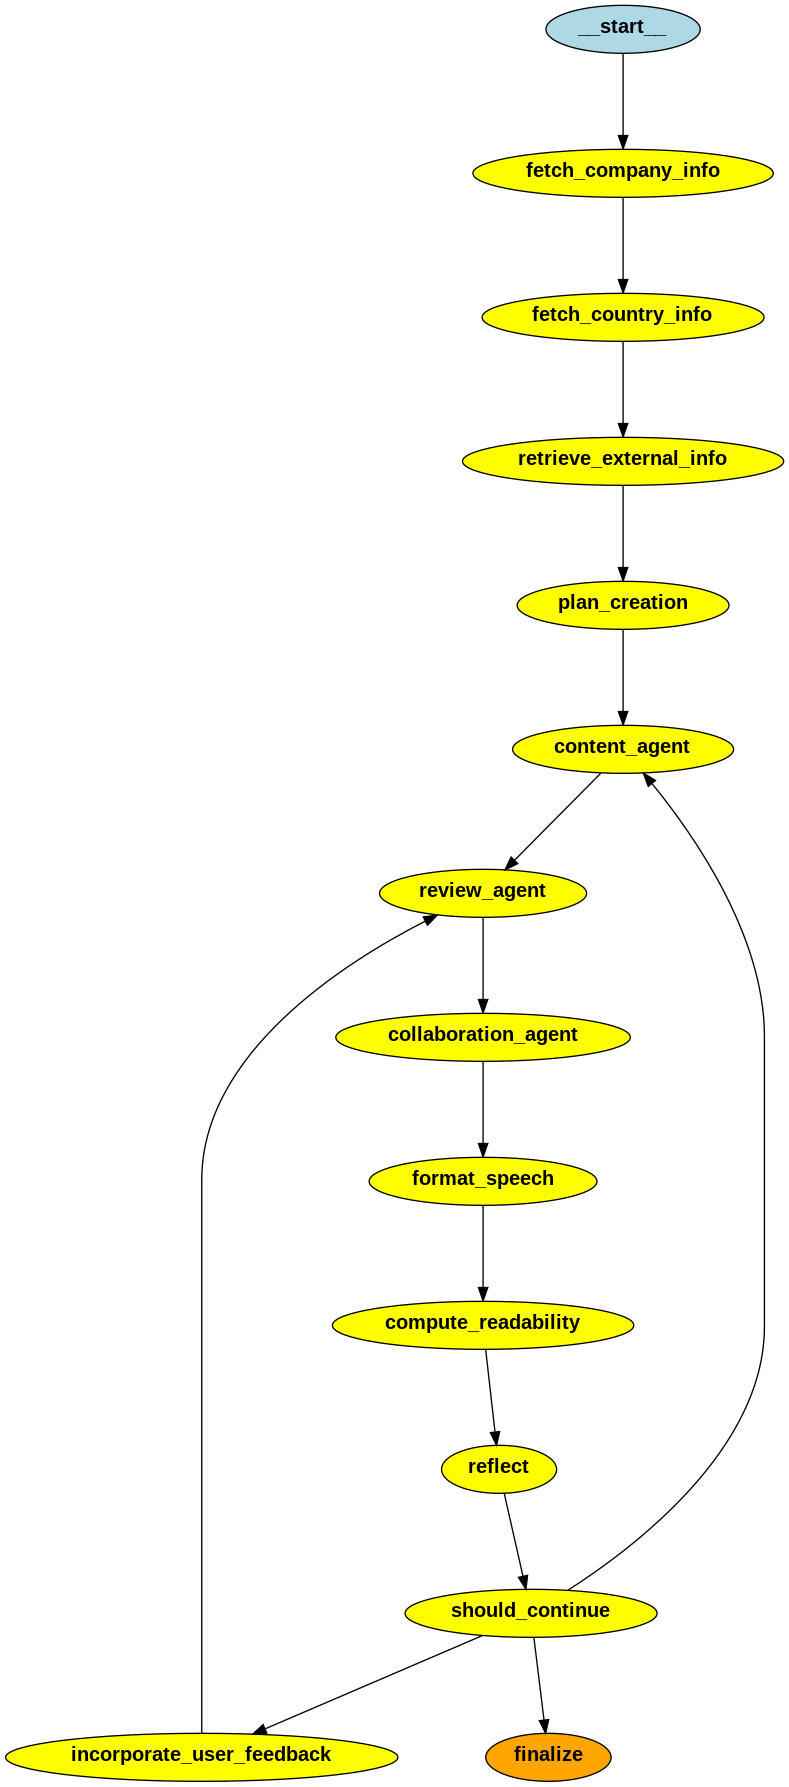

In [8]:
from IPython.display import Image, display
png_data = workflow_graph.get_graph().draw_png()
display(Image(png_data))

In [ ]:

def main() -> None:
    """
    Main function to run the entire agent workflow.
    
    The function validates the initial state, builds the workflow graph, and invokes it.
    """
    initial_state: AgentState = {
        "company_name": "Ethiopia Airlines",
        "country_name": "Ethiopia",
        "company_info": "",
        "country_info": "",
        "retrieved_info": [],
        "event_context": "Annual Conference 2025",
        "audience_profile": "Prime minister and others leaders",
        "plan": "",
        "content_draft": "",
        "review_feedback": "",
        "collaboration_draft": "",
        "formatted_speech": "",
        "reflection": "",
        "readability_score": 0.0,
        "draft_speech": "",
        "revision_number": 1,
        "max_revisions": MAX_REVISIONS,
        "user_feedback": ""  
    }
    
    try:
        validate_state(initial_state)
    except ValueError as ve:
        logging.error("Initial state validation error: %s", ve)
        return
    
    workflow_graph = build_workflow_graph()
    try:
        output = workflow_graph.invoke(initial_state, config={
            "configurable": {"thread_id": "session_text_only_v2"},
            "recursion_limit": 50  
        })
        logging.info("Final Agent Output:\n%s", output)
        print("\n=== Final Agent Output ===\n", output)
    except Exception as e:
        logging.error("Error during workflow execution: %s", e)

# Execute the workflow 
main()

Step 1 (Company Info):
 ETHIOPIAN THE LARGEST AIRLINE IN AFRICA FACT SHEET 2 Ethiopian Background Information Founded E December 21, 1945 Starting date of operation E April 08, 1946 Ownership E Government of Ethiopia (100%) Head Office E Bole International Airport, P .O. Box 1755 Addis Ababa, Ethiopia Fax: (+ 251)11661 1474 Reservations E Tel: (+251) 11 665 6666 Website E http://www.ethiopianairlines.com Chief Executive Officer E Mr. Tewolde GebreMariam Overview Ethiopian Airlines (Ethiopian) is the leading and most profitable airline in Africa. Tel: (+251-11) 517 8407/8656/8907/8165/8529/8913 Fax: (+251-11) 661 1474 E-mail:CorporateCommunication@ethiopianairlines.com www.twitter.com/flyethiopian www.youtube.com/flyethiopian www.facebook.com/ethiopianairlines.com http://plus.google.com/+ethiopianairlinescom http://instagram.com/fly.ethiopian www.ethiopianairlines.com Contact us on: Best Cargo Airline of the Year from Africa at the “2016 Cargo Airline of the Year” Air Cargo News awards 

2025-02-13 09:49:35,595 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-13 09:49:38,770 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Retrieved External Info:
 ["page_content='Ethiopian Airlines (Amharic: የኢትዮጵያ አየር መንገድ, romanized: Ye-Ītyōṗṗyā āyer menged), formerly Ethiopian Air Lines (EAL), is the flag carrier of Ethiopia, and is wholly owned by the country's government. EAL was founded on 21 December 1945 and commenced operations on 8 April 1946, expanding to international flights in 1951. The firm became a share company in 1965 and changed its name from Ethiopian Air Lines to Ethiopian Airlines.' metadata={'chunk_id': 0.0, 'doc_id': 'company_84', 'source': 'company'}", "page_content='The airline has been a member of the International Air Transport Association since 1959 and of the African Airlines Association (AFRAA) since 1968. Ethiopian is a Star Alliance member, having joined in December 2011. The company slogan is 'The New Spirit of Africa.' Ethiopian's hub and headquarters are at Bole International Airport in Addis Ababa, from where it serves a network of 155 passenger destinations—22 of them domestic—and 6

2025-02-13 09:50:10,621 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated Plan:
 Step 1: Understand the Purpose and Audience
The first step is to understand the purpose of the speech and the audience. In this case, the audience is the Prime Minister and other leaders, so the speech should be formal, respectful, and informative. The purpose of the speech could be to inform, persuade, or inspire, depending on the specific goals of the Annual Conference 2025.

Step 2: Gather Information
Start by gathering information about the company and the country. This could include the company's history, mission, values, achievements, and future plans. For the country, gather information about the current political, economic, and social situation, as well as future projections and challenges. Also, research about the Prime Minister and other leaders, their interests, and their concerns.

Step 3: Analyze the Information
Analyze the gathered information to identify key points that will be interesting and relevant to the audience. Look for connections between the co

2025-02-13 09:50:43,391 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 09:51:00,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 5: Content Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am honored to stand before you today at the Annual Conference 2025. I am here to share with you the story of Ethiopian Airlines, a beacon of resilience and growth, and how it mirrors the promising trajectory of our beloved nation, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's spirit of endurance and progress. Owned entirely by the Government of Ethiopia, our airline has grown to become the leading and most profitable airline in Africa, with its headquarters at Bole International Airport, Addis Ababa. Under the able leadership of our CEO, Mr. Tewolde GebreMariam, we have soared to new heights, connecting Africa to the world.

Our airline is more than just a carrier; it is a symbol of national pride and a catalyst for economic growth. With over 1.5 million people flying with us annuall

2025-02-13 09:51:34,400 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 09:52:05,435 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 7: Collaboration Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am deeply honored to stand before you today at the Annual Conference 2025. Today, I am here to share with you a story of resilience, growth, and national pride - the story of Ethiopian Airlines, and how it mirrors the promising trajectory of our beloved nation, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's spirit of endurance and progress. Owned entirely by the Government of Ethiopia, our airline has grown from a humble beginning to become the leading and most profitable airline in Africa, with its headquarters at Bole International Airport, Addis Ababa. 

Let me share with you a story that encapsulates our journey. In the early 1990s, we faced a significant challenge - the airline industry was hit hard by the global economic downturn. But under the visionary leadership of our 

2025-02-13 09:52:21,517 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 10: Reflection:
 Strengths:
1. The speech is well-structured with a clear introduction, body, and conclusion. 
2. The speaker effectively uses storytelling to engage the audience, sharing the history and growth of Ethiopian Airlines.
3. The speech is inspiring and motivational, encouraging the audience to support Ethiopian Airlines and invest in Ethiopia.
4. The speaker effectively links the success of Ethiopian Airlines to the economic growth of Ethiopia, demonstrating the airline's contribution to the nation's development.
5. The speaker ends the speech with a call to action, urging the audience to join in the journey of Ethiopia's growth.

Weaknesses:
1. The speech could benefit from more specific examples or anecdotes to make the story of Ethiopian Airlines more relatable and engaging.
2. The speaker could have included more data or statistics to support the claims about the airline's growth and its contribution to Ethiopia's economy.
3. The speech lacks a personal touch. The 

2025-02-13 09:52:45,994 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 09:53:01,868 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 5: Content Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am honored to stand before you today at the Annual Conference 2025. I am here to share with you the story of Ethiopian Airlines, a beacon of resilience and growth, and its role in the economic transformation of our beloved country, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's spirit of endurance and progress. Owned entirely by the Government of Ethiopia, our airline has grown to become the leading and most profitable airline in Africa, with our headquarters at Bole International Airport, Addis Ababa. Our CEO, Mr. Tewolde GebreMariam, has been instrumental in steering this growth, making Ethiopian Airlines "Africa's Link to the World."

Our airline serves more than 1.5 million people annually, connecting them to 22 domestic and 44 international destinations across four continents. We

2025-02-13 09:53:31,232 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 09:53:55,231 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 7: Collaboration Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am honored to stand before you today at the Annual Conference 2025. Today, I will share with you the inspiring journey of Ethiopian Airlines, its role in the economic transformation of Ethiopia, and our vision for the future.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's spirit of endurance and progress. Owned entirely by the Government of Ethiopia, our airline has grown to become the leading and most profitable airline in Africa, with our headquarters at Bole International Airport, Addis Ababa. Our CEO, Mr. Tewolde GebreMariam, has been instrumental in steering this growth, making Ethiopian Airlines "Africa's Link to the World."

Our airline serves more than 1.5 million people annually, connecting them to 22 domestic and 44 international destinations across four continents. We have been

2025-02-13 09:54:07,317 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 10: Reflection:
 Strengths:
1. The speech is well-structured with a clear introduction, body, and conclusion. 
2. The speaker effectively uses statistics and specific examples to support their points, which adds credibility to the speech.
3. The speaker successfully highlights the achievements of Ethiopian Airlines and its contribution to Ethiopia's economic growth.
4. The speaker ends the speech with a call to action, encouraging the audience to support Ethiopian Airlines and invest in Ethiopia.

Weaknesses:
1. The speech could benefit from more personal anecdotes or stories to make it more engaging and relatable to the audience.
2. The speaker could have elaborated more on the future plans of Ethiopian Airlines, which would give the audience a clearer picture of what to expect.
3. The speech lacks a strong emotional appeal, which could have made it more impactful.

Improvements for Future Iterations:
1. Incorporate personal stories or anecdotes: This can make the speech more eng

2025-02-13 09:54:33,536 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 09:54:51,971 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 5: Content Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am honored to stand before you today at the Annual Conference 2025. I am here to share with you the story of Ethiopian Airlines, a beacon of resilience and growth, and its role in the economic transformation of our beloved country, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's spirit of endurance and progress. Owned entirely by the Government of Ethiopia, our airline has grown to become the leading and most profitable airline in Africa, with our headquarters at Bole International Airport, Addis Ababa. Our CEO, Mr. Tewolde GebreMariam, has been instrumental in steering this growth, making Ethiopian Airlines "Africa's Link to the World."

Our airline serves more than 1.5 million people annually, connecting them to 22 domestic and 44 international destinations across four continents. We

2025-02-13 09:55:22,004 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 09:55:47,396 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 7: Collaboration Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am honored to stand before you today at the Annual Conference 2025. Today, I will share with you the inspiring journey of Ethiopian Airlines, its significant role in Ethiopia's economic transformation, and our vision for the future.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's spirit of endurance and progress. Owned entirely by the Government of Ethiopia, our airline has grown to become the leading and most profitable airline in Africa, with our headquarters at Bole International Airport, Addis Ababa. Our CEO, Mr. Tewolde GebreMariam, has been instrumental in steering this growth, making Ethiopian Airlines "Africa's Link to the World."

Our airline serves more than 1.5 million people annually, connecting them to 22 domestic and 44 international destinations across four continents. We ha

2025-02-13 09:56:01,399 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 10: Reflection:
 Strengths:
The speech is well-structured, with a clear introduction, body, and conclusion. The speaker effectively uses the platform to highlight the achievements of Ethiopian Airlines and its contribution to Ethiopia's economy. The speaker also successfully communicates the company's future vision and invites the audience to participate in their journey. The use of specific data and examples, such as the number of jobs created and the growth rate of the company, adds credibility to the speech. The speaker also effectively uses rhetorical devices such as repetition ("we are not just an airline; we are a symbol of national pride") to emphasize their points.

Weaknesses:
While the speech is informative, it lacks a personal touch or storytelling element that could make it more engaging and relatable to the audience. The speaker could have included personal anecdotes or stories to illustrate the points being made. Additionally, the speech could have benefited from a m

2025-02-13 09:56:25,160 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 09:56:43,902 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 5: Content Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am honored to stand before you today at the Annual Conference 2025. I am here to share with you the story of Ethiopian Airlines, a beacon of resilience and growth, and how it mirrors the promising trajectory of our beloved nation, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's enduring spirit. Owned entirely by the Government of Ethiopia, it has grown to become the leading and most profitable airline in Africa, with its headquarters at Bole International Airport, Addis Ababa. Under the able leadership of our CEO, Mr. Tewolde GebreMariam, we have soared to new heights, connecting Africa to the world.

Our airline is more than just a carrier; it is a symbol of national pride and a catalyst for economic growth. With over 1.5 million people flying with us annually to 22 domestic and 44 in

2025-02-13 09:57:18,313 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 09:57:49,444 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 7: Collaboration Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am deeply honored to stand before you today at the Annual Conference 2025. Today, I am here to share with you the inspiring journey of Ethiopian Airlines, a beacon of resilience and growth, and how it mirrors the promising trajectory of our beloved nation, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's enduring spirit. Owned entirely by the Government of Ethiopia, it has grown to become the leading and most profitable airline in Africa, with its headquarters at Bole International Airport, Addis Ababa. Under the visionary leadership of our CEO, Mr. Tewolde GebreMariam, we have soared to new heights, connecting Africa to the world.

Let me share a story that encapsulates our journey. In 2010, we faced a significant challenge when the global aviation industry was hit by the economi

2025-02-13 09:58:04,702 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 10: Reflection:
 Strengths:
1. The speech is well-structured with a clear introduction, body, and conclusion. 
2. The speaker effectively uses storytelling to engage the audience, sharing the history and growth of Ethiopian Airlines.
3. The speaker successfully links the growth of Ethiopian Airlines to the economic development of Ethiopia, demonstrating the airline's contribution to the country's economy.
4. The speech ends with a strong call to action, inviting the audience to invest in Ethiopian Airlines and Ethiopia's future.

Weaknesses:
1. The speech could benefit from more specific examples or anecdotes to make the story of Ethiopian Airlines more relatable and engaging.
2. The speaker could have included more data or statistics to support the claims about the airline's growth and its impact on Ethiopia's economy.
3. The speech lacks a personal touch. The speaker could have shared personal experiences or stories to make the speech more engaging and memorable.

Improvements f

2025-02-13 09:58:30,610 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 09:58:46,482 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 5: Content Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am honored to stand before you today at the Annual Conference 2025. I am here to share with you the story of Ethiopian Airlines, a beacon of resilience and growth, and how it mirrors the promising trajectory of our beloved nation, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's enduring spirit. Owned entirely by the Government of Ethiopia, it has grown to become the leading and most profitable airline in Africa, with its headquarters at Bole International Airport, Addis Ababa. Under the able leadership of our CEO, Mr. Tewolde GebreMariam, we have soared to new heights, connecting Africa to the world.

Our airline is more than just a carrier; it is a symbol of national pride and a catalyst for economic growth. With over 1.5 million people flying with us annually to 22 domestic and 44 in

2025-02-13 09:59:08,293 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 09:59:38,092 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 7: Collaboration Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am deeply honored to stand before you today at the Annual Conference 2025. Today, I will share with you the inspiring journey of Ethiopian Airlines, a beacon of resilience and growth, and how it mirrors the promising trajectory of our beloved nation, Ethiopia.

Founded on December 21, 1945, and operational since April 08, 1946, Ethiopian Airlines is a testament to Ethiopia's enduring spirit. Owned entirely by the Government of Ethiopia, it has grown to become the leading and most profitable airline in Africa, with its headquarters at Bole International Airport, Addis Ababa. Under the able leadership of our CEO, Mr. Tewolde GebreMariam, we have soared to new heights, connecting Africa to the world.

Let me share a brief anecdote that encapsulates our journey. In the early 1990s, when the airline industry was grappling with the aftermath of the Gulf War and ri

2025-02-13 09:59:52,941 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 10: Reflection:
 Strengths:
The speech is well-structured, with a clear introduction, body, and conclusion. The speaker effectively uses the story of Ethiopian Airlines to illustrate the broader economic growth and transformation of Ethiopia. The speech is also inspiring and motivational, inviting the audience to join in the journey of growth and transformation. The speaker also effectively uses statistics and facts to support their points, which adds credibility to the speech. The call to action at the end of the speech is also a strong point, as it invites the audience to participate in the discussion and contribute their ideas.

Weaknesses:
While the speech is generally well-written, it could benefit from more specific examples and stories to make it more engaging and relatable. For example, the speaker could share specific stories of challenges that Ethiopian Airlines has overcome, or success stories of how the airline has contributed to economic growth in Ethiopia. The speech

2025-02-13 10:00:15,576 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 10:00:34,215 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 5: Content Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am honored to stand before you today at the Annual Conference 2025. I am here to share with you the story of Ethiopian Airlines, a beacon of resilience and growth, and its role in the economic transformation of our beloved country, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's spirit of endurance and progress. Owned entirely by the Government of Ethiopia, our airline has grown to become the leading and most profitable airline in Africa, a feat that fills us with immense pride.

Our journey has been marked by numerous accolades, including the "Best Cargo Airline of the Year from Africa" at the 2016 Cargo Airline of the Year awards. Our strategic plans have always been ambitious, aiming to reach a revenue target of US$1 billion, increasing our fleet to 30 jet aircraft, and expanding ou

2025-02-13 10:01:03,916 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 10:01:48,471 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 7: Collaboration Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am deeply honored to stand before you today at the Annual Conference 2025. Today, I am here to share with you a story of resilience, growth, and transformation. This is the story of Ethiopian Airlines, a beacon of hope and progress, and its pivotal role in the economic metamorphosis of our beloved country, Ethiopia.

Ethiopian Airlines, born on December 21, 1945, and taking its first flight on April 08, 1946, is a living testament to Ethiopia's spirit of endurance and progress. Owned entirely by the Government of Ethiopia, our airline has soared to become the leading and most profitable airline in Africa, a feat that fills us with immense pride.

Let me take you back to 2016, a year that marked a significant milestone in our journey. We were honored with the "Best Cargo Airline of the Year from Africa" at the Cargo Airline of the Year awards. This was not ju

2025-02-13 10:02:09,466 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 10: Reflection:
 Strengths:
1. The speech is well-structured with a clear introduction, body, and conclusion. 
2. The speaker effectively uses storytelling to engage the audience, sharing the history and achievements of Ethiopian Airlines.
3. The speaker successfully positions Ethiopian Airlines as a symbol of Ethiopia's resilience, ambition, and potential, which is a powerful message.
4. The speech includes specific details and data to support the points being made, which adds credibility.
5. The speaker makes a strong call to action at the end, urging the audience to support and invest in African businesses.

Weaknesses:
1. The speech could benefit from more personal anecdotes or stories to make it more relatable and engaging.
2. The speaker could have included more about the challenges Ethiopian Airlines has faced and how they overcame them, to further highlight their resilience.
3. The speech could have been more interactive, perhaps by asking rhetorical questions or seeking a

2025-02-13 10:02:42,636 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 10:03:00,569 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 5: Content Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am honored to stand before you today at the Annual Conference 2025. I am here to share with you the story of Ethiopian Airlines, a beacon of resilience and growth, and how it mirrors the promising trajectory of our beloved nation, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's enduring spirit. Owned entirely by the Government of Ethiopia, our airline has grown to become the leading and most profitable airline in Africa, with its headquarters at Bole International Airport, Addis Ababa. Our CEO, Mr. Tewolde GebreMariam, has been instrumental in steering this growth, making Ethiopian Airlines "Africa's Link to the World."

Our airline serves more than 1.5 million people annually, connecting them to 22 domestic and 44 international destinations across four continents. We have been recogni

2025-02-13 10:03:36,398 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 10:04:00,792 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 7: Collaboration Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am deeply honored to stand before you today at the Annual Conference 2025. Today, I will share with you the inspiring journey of Ethiopian Airlines, a beacon of resilience and growth, and how it mirrors the promising trajectory of our beloved nation, Ethiopia.

Our discussion will unfold in three parts. First, we will delve into the history and achievements of Ethiopian Airlines. Second, we will explore how the airline's growth reflects Ethiopia's economic landscape. Finally, we will look at the future prospects of both the airline and our nation.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's enduring spirit. Owned entirely by the Government of Ethiopia, our airline has grown to become the leading and most profitable airline in Africa, with its headquarters at Bole International Airport,

2025-02-13 10:04:12,979 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 10: Reflection:
 Strengths:
1. The speech is well-structured with a clear introduction, body, and conclusion. The speaker sets the agenda at the beginning, which helps the audience follow the flow of the speech.
2. The speaker effectively uses storytelling to engage the audience, such as the story of Ethiopian Airlines' resilience in 2010.
3. The speaker makes a strong connection between the success of Ethiopian Airlines and the economic growth of Ethiopia, which reinforces the main theme of the speech.
4. The speaker ends with a call to action, encouraging the audience to learn more about Ethiopian Airlines and consider Ethiopia for future business ventures.

Weaknesses:
1. The speech could benefit from more specific examples and data to support the claims made about Ethiopian Airlines' success and Ethiopia's economic growth.
2. The speaker could have included more personal anecdotes or experiences to make the speech more relatable and engaging.
3. The speech lacks a strong emoti

2025-02-13 10:04:47,399 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 10:05:05,014 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 5: Content Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am honored to stand before you today at the Annual Conference 2025. I am here to share with you the story of Ethiopian Airlines, a beacon of resilience and growth, and its role in the economic transformation of our beloved country, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's spirit of endurance and progress. Owned entirely by the Government of Ethiopia, our airline has grown to become the leading and most profitable airline in Africa, with our headquarters at Bole International Airport, Addis Ababa. Our CEO, Mr. Tewolde GebreMariam, has been instrumental in steering this growth, making Ethiopian Airlines "Africa's Link to the World."

Our airline serves more than 1.5 million people annually, connecting them to 22 domestic and 44 international destinations across four continents. We

2025-02-13 10:05:37,267 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 10:06:09,538 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Step 7: Collaboration Agent Draft:
 Ladies and Gentlemen, Honorable Prime Minister, esteemed leaders, and distinguished guests, I am deeply honored to stand before you today at the Annual Conference 2025. Today, I am here to share with you the inspiring journey of Ethiopian Airlines, a beacon of resilience and growth, and its pivotal role in the economic transformation of our beloved country, Ethiopia.

Ethiopian Airlines, founded on December 21, 1945, and operational since April 08, 1946, is a testament to Ethiopia's spirit of endurance and progress. Owned entirely by the Government of Ethiopia, our airline has grown to become the leading and most profitable airline in Africa, with our headquarters at Bole International Airport, Addis Ababa. Our CEO, Mr. Tewolde GebreMariam, has been instrumental in steering this growth, making Ethiopian Airlines "Africa's Link to the World."

Our airline serves more than 1.5 million people annually, connecting them to 22 domestic and 44 international

2025-02-13 10:06:30,435 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-13 10:06:30,445 - ERROR - Error during workflow execution: Recursion limit of 50 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


Step 10: Reflection:
 Strengths:
1. The speech is well-structured with a clear introduction, body, and conclusion. 
2. It provides a comprehensive overview of Ethiopian Airlines, its history, achievements, and contributions to Ethiopia's economy.
3. The speaker effectively uses statistics and specific examples to support their points, which adds credibility to the speech.
4. The speech is inspiring and motivational, highlighting the potential of Ethiopia and its people.
5. The use of a local proverb at the end of the speech adds a cultural touch and emphasizes the theme of unity and collaboration.

Weaknesses:
1. The speech could benefit from a more personal touch. The speaker could share personal experiences or stories to make the speech more engaging and relatable.
2. The speech is quite factual and could use more emotional appeal to engage the audience on a deeper level.
3. The speaker could have addressed potential challenges and how Ethiopian Airlines plans to overcome them. This 